In [89]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
from torchvision import datasets

# Getting dataset

In [2]:

cifar10 = datasets.CIFAR10(".", train=True, download=True, transform = transforms.ToTensor())
cifar10_val = datasets.CIFAR10(".", train=False, download=True, transform = transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [3]:
img1, label1 = cifar10[0]
img1.shape, img1.dtype

(torch.Size([3, 32, 32]), torch.float32)

In [4]:
torch.max(img1), torch.min(img1)

(tensor(1.), tensor(0.))

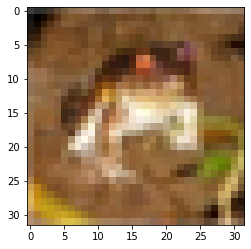

In [5]:
import matplotlib.pyplot as plt
plt.imshow(img1.permute(1, 2, 0))

## Normalizing the dataset

In [6]:
cifar10.data.shape

(50000, 32, 32, 3)

In [7]:
imgs = torch.stack([img_t for img_t, _ in cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [8]:
mean = imgs.view(3, -1).mean(dim=1)
std = imgs.view(3, -1).std(dim=1)
mean, std

(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2470, 0.2435, 0.2616]))

## Creating a transform to normalize the data

In [9]:
normalize_transform = transforms.Compose([
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616]),
transforms.ToTensor()])

## Creating transformed dataset + dataloader

### Here I did a lot of errors cause:
### first the imgs are in PIL so you have to change them in tensors
### and if you have already them in tensor ig don't use ToTensor() then


In [14]:
cifar10 = datasets.CIFAR10('.', 
                           download=False, 
                           train=True,
                           transform=
                           transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize(
                                   mean=[0.4914, 0.4822, 0.4465], 
                                   std=[0.2470, 0.2435, 0.2616])]))

cifar10_val = datasets.CIFAR10('.', 
                               download=False, 
                               train=False,
                               transform=transforms.Compose([
                               transforms.ToTensor(),
                                   transforms.Normalize(
                                       mean=[0.4914, 0.4822, 0.4465], 
                                       std=[0.2470, 0.2435, 0.2616])]))

In [15]:
train_dataloader = DataLoader(cifar10, shuffle=True, batch_size=32)
test_dataloader = DataLoader(cifar10_val, shuffle=False, batch_size=32)

In [28]:
classes = cifar10.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 32, 32])


(-0.5, 31.5, 31.5, -0.5)

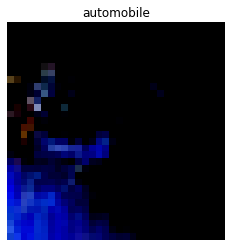

In [29]:
img, label = next(iter(train_dataloader))
print(img.shape)
plt.imshow(img[1].permute(1, 2, 0))
plt.title(classes[1])
plt.axis("off")

## Making model (Resnet)

In [62]:
import torch.nn.functional as F
class ResBlock(nn.Module):
    """
    This is one block of the ResNet
    """
    def __init__(self, n_channels=3):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_channels, n_channels, padding=1, kernel_size=3)
        self.batch_norm = nn.BatchNorm2d(n_channels)
        
        ## weight initialization
        nn.init.kaiming_normal_(self.conv.weight, nonlinearity="relu")
        nn.init.constant_(self.batch_norm.weight,val=0.5)
        nn.init.zeros_(self.batch_norm.bias)
        
    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = F.relu(out) + x
        return out

In [236]:
class ResNet(nn.Module):
    """
    ResNet implemented
    This is simply staking ResBlock
    """
    def __init__(self, n_channels=32, n_block=10):
        super().__init__()
        self.first_block = nn.Conv2d(3, n_channels, padding=1, kernel_size=3)
        ## making blocks using ResBlock and then multiplying it with n_block
        ## to get the desired number of blocks and then unpacking using *
        ## (10 * [ResBlock(...)]) and then simply unpack it
        self.resblocks = nn.Sequential(
        *(n_block * [ResBlock(n_channels)]))
        
        
        self.fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(32768, 64),
        nn.Linear(64, 32),
        nn.Linear(32, len(classes)))
        
    def forward(self, x):
        out = self.first_block(x)
        out = self.resblocks(out)
        out = F.softmax(self.fc(out), dim=1)
        return out

In [237]:
test = ResNet(n_block=10)
print(test(img[0].unsqueeze(0)).shape, img[0].unsqueeze(0).shape)
test(img).shape, img.shape

torch.Size([1, 10]) torch.Size([1, 3, 32, 32])


(torch.Size([32, 10]), torch.Size([32, 3, 32, 32]))

## Setting up optimizer and loss

In [238]:
model0 = ResNet()
optimizer = optim.Adam(params=model0.parameters())
loss_fn = nn.CrossEntropyLoss()

## Training loop

In [240]:
img, label = next(iter(test_dataloader))
out = model0(img)
print(loss_fn(out, label), out.shape, label.shape)
acc = torch.sum(torch.argmax(out, dim=1) == label)

tensor(2.3008, grad_fn=<NllLossBackward0>) torch.Size([32, 10]) torch.Size([32])


In [241]:
def train_step(model: nn.Module,
              optimizer: torch.optim.Optimizer,
              epochs: int,
              train_dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    
    train_loss = []
    model.train()
    for epoch in range(epochs):
        for i, (imgs, labels) in enumerate(train_dataloader):
            if (i%1000 == 0):
                print(i)
            predictions = model(imgs)
            loss = loss_fn(predictions, labels)
            
            train_loss.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
    return train_loss

In [242]:
def test_step(model: nn.Module,
              test_dataloader: torch.utils.data.DataLoader):
    
    acc = 0
    model.eval()
    with torch.inference_mode():
        for imgs, labels in test_dataloader  :
            prediction = model(imgs)
            
            acc += torch.sum(torch.argmax(prediction, dim=1) == labels).item()
    acc = acc / len(test_dataloader.dataset)
    return acc
            

In [243]:
for i, (img, label) in enumerate(train_dataloader):
    print(i)
    if i == 0:
        break

0


In [244]:
train_loss = train_step(
model=model0,
optimizer=optimizer,
epochs=1,
train_dataloader=train_dataloader,
loss_fn=loss_fn)

0
1000


In [245]:
new_loss = list(map(lambda x: sum(x)/32, [train_loss[i:i+32] for i in range(0, len(train_loss), 32)] ))

In [246]:
len(new_loss), len(train_loss)/32

(49, 48.84375)

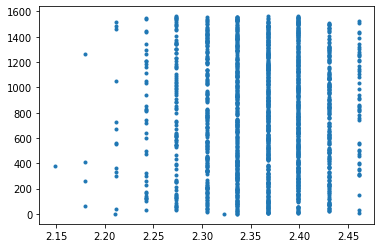

In [247]:
plt.plot(train_loss, np.arange(len(train_loss)), '.')

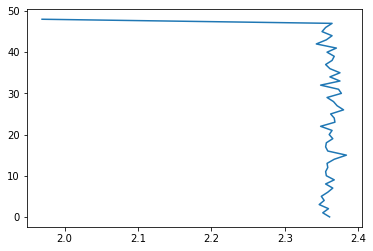

In [248]:
plt.plot(new_loss, np.arange(len(new_loss)))

In [249]:
acc = test_step(model=model0,
               test_dataloader=test_dataloader)

In [250]:
len(test_dataloader.dataset)

10000

In [251]:
acc

0.1

In [252]:
acc = test_step(model=model0,
               test_dataloader=train_dataloader)

In [253]:
acc

0.1